# How to create a multi-sign transaction 

A multi-sign transaction is like a shared account.  
The funds locked in the account can only be spend if the transaction is signed by the owners. 

### 1) Create the Native Script 

The funds locked in a script of type `all` can only be spent if all the owners sign the transaction.

In [47]:
%%bash
# get the verification key from the owner 1 (Djessy)
vKeyOwner1=/users/$(whoami)/testnet/priv/wallet/Djessy/djessy.addr.vkey
keyHashOwner1=$(cardano-cli address key-hash --payment-verification-key-file $vKeyOwner1)

# get the verification key from the owner 2 (Drake)
vKeyOwner2=/users/$(whoami)/testnet/priv/wallet/Drake/drake.addr.vkey
keyHashOwner2=$(cardano-cli address key-hash --payment-verification-key-file $vKeyOwner2)

# Create the script
echo "{" >> scriptAll.policy
echo "  \"type\": \"all\"," >> scriptAll.policy
echo "  \"scripts\":" >> scriptAll.policy
echo "  [" >> scriptAll.policy
echo "    {" >> scriptAll.policy
echo "      \"type\": \"sig\"," >> scriptAll.policy
echo "      \"keyHash\": \"$keyHashOwner1\"" >> scriptAll.policy
echo "    }," >> scriptAll.policy
echo "    {" >> scriptAll.policy
echo "      \"type\": \"sig\"," >> scriptAll.policy
echo "      \"keyHash\": \"$keyHashOwner2\"" >> scriptAll.policy
echo "    }" >> scriptAll.policy
echo "  ]" >> scriptAll.policy
echo "}" >> scriptAll.policy

# Show the script in the consol
cat scriptAll.policy

{
  "type": "all",
  "scripts":
  [
    {
      "type": "sig",
      "keyHash": "484a3a18672bad13acb4a4269af49f2d535a9c145592ca00170b3f36"
    },
    {
      "type": "sig",
      "keyHash": "8f1935255031112e57874e0361d0c62125791f5b4a6a2064f220e37a"
    }
  ]
}


### 2) Create the native script address

In [63]:
%%bash
# Create the script address
cardano-cli address build \
--payment-script-file scriptAll.policy  \
--testnet-magic 1 \
--out-file scriptAll.addr

# Bech32 encoded address
echo $(cat scriptAll.addr)
# Bech32 decoded address
echo $(bech32 <<< $(cat scriptAll.addr))

addr_test1wzlh2pphxzv566a3yuqntq6wrt00pr3mpczks72azhzhppczfl7yr
70bf75043730994d6bb1270135834e1adef08e3b0e0568795d15c57087


### Send funds to the script address and get the UTXO from the script 

In [67]:
%%bash
cardano-cli query utxo \
--address addr_test1wzlh2pphxzv566a3yuqntq6wrt00pr3mpczks72azhzhppczfl7yr \
--testnet-magic 1

                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
c4d93311503365b2329ee35d4fdae6d6a0f22916115459eef8eb6dbeefbbf120     0        10000000000 lovelace + TxOutDatumNone


### 3) Build the transaction on-chain (using build command)

In [77]:
%%bash
CHANGE_ADDR=$(cat policy/scriptAll.addr)
RECEIVER_ADDR=$(cat /users/$(whoami)/testnet/priv/wallet/Lola/lola.addr)
OUTPUT=9500000000

# Build the transaction
cardano-cli transaction build \
--tx-in c4d93311503365b2329ee35d4fdae6d6a0f22916115459eef8eb6dbeefbbf120#0 \
--change-address $CHANGE_ADDR \
--tx-out $RECEIVER_ADDR+$OUTPUT \
--tx-in-script-file policy/scriptAll.policy \
--witness-override 2 \
--out-file tx-files/tx-one.raw \
--testnet-magic 1

# Get the signature from all the owners
cardano-cli transaction witness \
--signing-key-file /users/$(whoami)/testnet/priv/wallet/Djessy/djessy.addr.skey \
--tx-body-file tx-files/tx-one.raw  \
--out-file tx-files/djessy.witness

cardano-cli transaction witness \
--signing-key-file /users/$(whoami)/testnet/priv/wallet/Drake/drake.addr.skey \
--tx-body-file tx-files/tx-one.raw  \
--out-file tx-files/drake.witness

# Assemble the transaction 
cardano-cli transaction assemble \
--tx-body-file tx-files/tx-one.raw \
--witness-file tx-files/djessy.witness \
--witness-file tx-files/drake.witness \
--out-file tx-files/tx-one.signed

Estimated transaction fee: Lovelace 173201


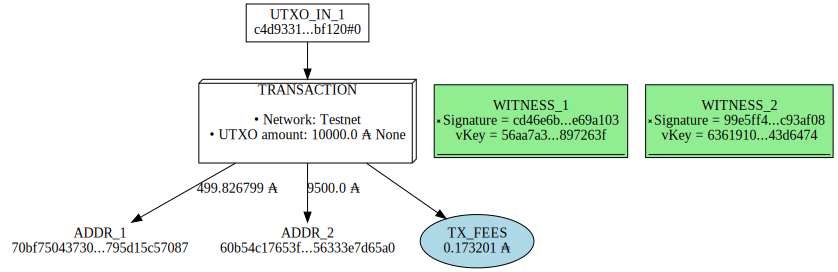

In [1]:
from IPython.display import SVG
from cardano_py_tools import transaction as tx
tx.vizualisation(txFile="tx-files/tx-one.signed", saveTo="tx-files/tx-one.svg")
SVG("tx-files/tx-one.svg")

### Submit the transaction

In [80]:
%%bash
# Submit the transaction
cardano-cli transaction submit \
--tx-file tx-files/tx-one.signed \
--testnet-magic 1

Transaction successfully submitted.


### Check the balance of the native script

In [82]:
%%bash
cardano-cli query utxo \
--address addr_test1wzlh2pphxzv566a3yuqntq6wrt00pr3mpczks72azhzhppczfl7yr \
--testnet-magic 1

                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
98b172afe15ce5b0efb28bd604431cdd23f8351f90271415f86e782087337872     0        499826799 lovelace + TxOutDatumNone


# Others types of scripts

### - Any

The funds locked in a script of type `any` can only be spend if one of the address owners sign the transaction.

In [85]:
# Examples of script using the type any
!cat policy/scriptAny.policy

{
  "type": "any",
  "scripts":
  [
    {
      "type": "sig",
      "keyHash": "45e35c668298a740e4b39e192c37fdf6014b9eb9a2d45134a863b2b5"
    },
    {
      "type": "sig",
      "keyHash": "3933c66d722b50c90f70e34dfd76899e299b80567ba6980c1f4e0050"
    },
    {
      "type": "sig",
      "keyHash": "835bb523508858ef8167f3a88423f3287dd4ffcf86d23825a1cae438"
    }
  ]
}


### - AtLeast
The funds locked in a script of type `atLeast` can only be spend if there is atLeast the X number of signature required.

In [86]:
# Examples of script using the type atLeast
!cat policy/scriptAtLeast.policy

{
  "type": "atLeast",
  "required": 2,
  "scripts":
  [
    {
      "type": "sig",
      "keyHash": "45e35c668298a740e4b39e192c37fdf6014b9eb9a2d45134a863b2b5"
    },
    {
      "type": "sig",
      "keyHash": "3933c66d722b50c90f70e34dfd76899e299b80567ba6980c1f4e0050"
    },
    {
      "type": "sig",
      "keyHash": "835bb523508858ef8167f3a88423f3287dd4ffcf86d23825a1cae438"
    }
  ]
}


### - After 

You can specify a slot after which the signature is allowed.  
Before the slot x you can't spend the funds and but after the slot x you can.

In [88]:
# Examples of script using the type after
!cat policy/scriptAfter.policy

{
  "type": "all",
  "scripts":
  [
    {
      "type": "after",
      "slot": 8278668
    },
    {
      "type": "sig",
      "keyHash": "45e35c668298a740e4b39e192c37fdf6014b9eb9a2d45134a863b2b5"
    }
  ]
}


### - Before 

You can specify a slot until wich the signature is allowed.  
Before the slot x you can spend the fund but after the slot x you can't.

In [89]:
# Examples of script using the type after
!cat policy/scriptBefore.policy

{
  "type": "any",
  "scripts":
  [
    {
      "type": "before",
      "slot": 8107662
    },
    {
      "type": "sig",
      "keyHash": "45e35c668298a740e4b39e192c37fdf6014b9eb9a2d45134a863b2b5"
    },
    {
      "type": "sig",
      "keyHash": "3933c66d722b50c90f70e34dfd76899e299b80567ba6980c1f4e0050"
    },
    {
      "type": "sig",
      "keyHash": "835bb523508858ef8167f3a88423f3287dd4ffcf86d23825a1cae438"
    }
  ]
}


In [2]:
!jupytext --to markdown how-to-create-a-multi-sign-tx.ipynb

[jupytext] Reading how-to-create-a-multi-sign-tx.ipynb in format ipynb
[jupytext] Writing how-to-create-a-multi-sign-tx.md
